In [16]:
from xbbg import blp

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

import shap

import datetime
from dateutil.relativedelta import relativedelta

In [40]:
factors_jpy = ["USDJPY CURNCY", "ES1 INDEX", "USGG2Y INDEX", "USGG10Y INDEX", "UX1 INDEX", "TZT1 COMDTY"]
names_jpy = ["USDJPY", "SPX", "2Y TREASURY", "10Y TREASURY", "VIX", "EU NATGAS"]
log_flag_jpy = [True, True, False, False, False, True]

factors_eur = ["EURUSD CURNCY", "ES1 INDEX", "USGG2Y INDEX", "USGG10Y INDEX", "CO1 COMDTY", "UX1 INDEX", "TZT1 COMDTY", "GDBR2 INDEX", "VGA INDEX", "GBTPGR10 INDEX"]
names_eur = ["EURUSD", "SPX", "2Y TREASURY", "10Y TREASURY", "BRENT CRUDE", "VIX", "EU NATGAS", "2Y BUND", "SX5E", "10Y BTP"]
log_flag_eur = [True, True, False, False, True, False, True, False, True, False]

factors_AUD = ["AUDUSD CURNCY", "ES1 INDEX", "USGG2Y INDEX", "USGG10Y INDEX", "CO1 COMDTY", "UX1 INDEX", "GACGB10 INDEX", "IOEA COMDTY"]
names_AUD = ["AUDUSD", "SPX", "2Y TREASURY", "10Y TREASURY", "BRENT CRUDE", "VIX", "10Y ACGB", "IRON ORE"]
log_flag_AUD = [True, True, False, False, True, False, False, True]

factors_eur_new = ["EURUSD CURNCY", ".EUUS10 U Index", ".BUNDBTP F Index", "TZT1 Comdty", "CO1 COMDTY", "ES1 INDEX", "SX5E INDEX", "VIX Index", ".EUUS1 U INDEX", "GBTPGR2 INDEX", "GDBR2 INDEX"]
names_eur_new = ["EURUSD", "10Y EU-US Swap Diff", "10Y Bund-BTP", "EU NATGAS", "BRENT CRUDE", "S&P", "SX5E", "VIX", "1Y EU-US Swap Diff", "2y BTP", "2y BUND"]
log_flag_eur_new = [True, False, False, True, True, True, True, False, False, False, False]

In [41]:
def hist_data(tickers, start_date, end_date, condition = "LAST_PRICE"):
    # Return a matrix of prices, with modifiable pricing condition
    data = blp.bdh(tickers, condition, start_date,end_date)
    data = data.dropna()
    clean_cols = []
    for col in data.columns:
        clean_cols.append(col[0])
    data.columns = clean_cols
    return data


In [62]:
def ridge_decomp(label, tickers, lookback_days, diff = True, names = None, log_flag = None):
    
    # Pull Data; Calculate Diffs; Drop NA
    end_date = datetime.date.today()
    start_date = end_date-relativedelta(days = lookback_days)
    df = hist_data(tickers = tickers, start_date = start_date, end_date = end_date)
    
    # Take log of certain series if that's called for, scale * 100 if so, to match with rates scaling
    if log_flag is not None:
        for x in range(0, len(df.columns)):
            if log_flag[x] == True:
                df.iloc[:,x] = df.iloc[:,x].apply(lambda x: 100*np.log(x))
    
    #df = df.apply(lambda x: np.log(x)*100)
    if diff == True:
        df = df.diff()
        df.dropna(inplace = True)
    
    # Rename Columns for Visual Presentation
    if names is not None:
        df.columns = names

    # Ridge Regression   
    dep_var = df[label]
    indep_var = df.drop(columns = label)
    print(indep_var.iloc[-1,:])
    
    # Note we fit to everything but today's label
    model_sk = Ridge()
    model_sk.fit(indep_var.iloc[:-1,:], dep_var.iloc[:-1])
    
    cv = RepeatedKFold(n_splits=30, n_repeats=3, random_state=1)
    scores = cross_val_score(model_sk, indep_var, dep_var, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    scores = np.absolute(scores)
    print('RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
    
    # SHAP Computations
    X1000 = shap.utils.sample(indep_var, 1000)
    explainer = shap.Explainer(model_sk.predict, X1000)
    
    shap_values = explainer(indep_var)
    shap.plots.waterfall(shap_values[-1], max_display=14, show=False)
    plt.title("%s 1-Day Theoretical Return by Component\n"%(label), fontsize = 16)
    plt.xlabel("Factor % Impact on Return", fontsize = 14)
    plt.show()
    
    shap.plots.bar(shap_values, show = False)
    plt.title("%s Average Absolute 1-Day Factor Impacts, %s Day Lookback"%(label, lookback_days), fontsize = 16)
    plt.xlabel("Abs Factor Impact, %")
    plt.show()

10Y EU-US Swap Diff    0.023500
10Y Bund-BTP          -0.012300
EU NATGAS              2.351660
BRENT CRUDE           -1.326154
S&P                    0.734175
SX5E                   0.053519
VIX                   -0.580000
1Y EU-US Swap Diff     0.076100
2y BTP                 0.057000
2y BUND                0.079000
Name: 2022-07-19, dtype: float64
RMSE: 0.491 (0.194)


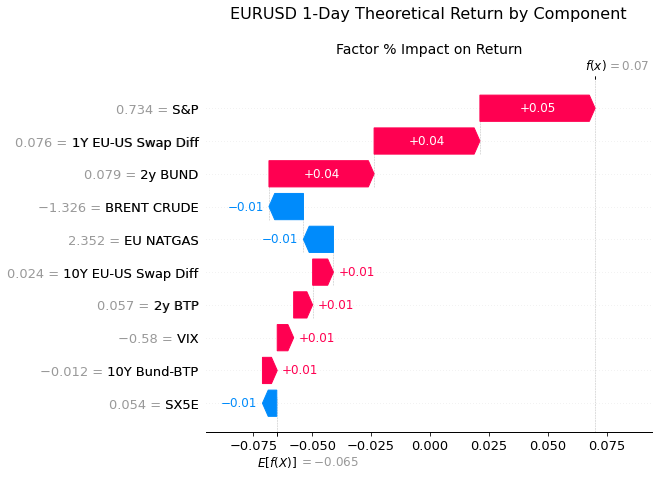

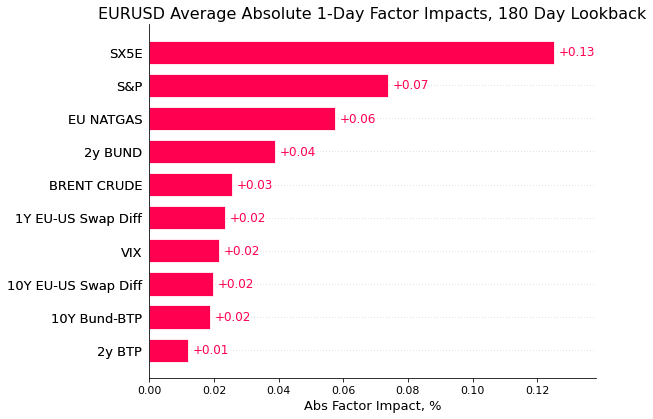

In [64]:
ridge_decomp(label = "EURUSD", tickers = factors_eur_new, lookback_days = 180, names = names_eur_new, log_flag = log_flag_eur_new)